In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

i_1=pd.read_csv('~/git/BD/temp/imp_fert_mun1.csv').sort_values(by=['CO_ANO','CO_MES'])\
.rename(columns={'SH4':'CO_SH4'})

uf=pd.read_csv('~/git/BD/Comexstat/tab_complementares/UF.csv',encoding='Latin-1',sep=';')
pais=pd.read_csv('~/git/BD/Comexstat/tab_complementares/PAIS.csv',encoding='Latin-1',sep=';')
mun=pd.read_csv('~/git/BD/Comexstat/tab_complementares/UF_MUN.csv',encoding='Latin-1',sep=';')\
.rename(columns={'CO_MUN_GEO':'CO_MUN'})
sh=pd.read_csv('~/git/BD/Comexstat/tab_complementares/NCM_SH.csv',encoding='Latin-1',sep=';')
ncm=pd.read_csv('~/git/BD/Comexstat/tab_complementares/NCM.csv',encoding='Latin-1',sep=';')

i_1=i_1[i_1.SG_UF_MUN=='BA'].drop(columns='SG_UF_MUN')
i_1=i_1[i_1.CO_ANO>=2018]
i_1['date']=pd.to_datetime(i_1.CO_ANO.astype(str)+'/'+i_1.CO_MES.astype(str)+'/1')
date_min=i_1.date.min()
date_max=i_1.date.max()

i_1[['date','CO_SH4','CO_PAIS','CO_MUN']]=i_1[['date','CO_SH4','CO_PAIS','CO_MUN']].astype('category')

i_1=i_1.groupby(by=['date','CO_SH4','CO_PAIS','CO_MUN'],observed=False)[['KG_LIQUIDO','VL_FOB']].sum()\
.reset_index()

i_1[['CO_SH4','CO_PAIS','CO_MUN']]=i_1[['CO_SH4','CO_PAIS','CO_MUN']].astype(str)

i_1['date']=i_1['date'].astype('datetime64[ns]')

i_1=i_1[(i_1.date>=date_min)&(i_1.date<=date_max)]

i_1=i_1.merge(mun[['NO_MUN','CO_MUN']].drop_duplicates().astype(str))\
.merge(pais[['NO_PAIS','CO_PAIS']].drop_duplicates().astype(str))\
.merge(sh[['NO_SH4_POR','CO_SH4']].drop_duplicates().astype(str))

# Bahia

In [2]:
i_ba=i_1.groupby(by=['date'])[['VL_FOB','KG_LIQUIDO']].sum().reset_index()

i_ba['kg_12']=i_ba.rolling(12).KG_LIQUIDO.sum()
i_ba['fob_12']=i_ba.rolling(12).VL_FOB.sum()
i_ba['dif_kg']=i_ba.kg_12-i_ba.shift(1).kg_12
i_ba['dif_fob']=i_ba.fob_12-i_ba.shift(1).fob_12

In [3]:
i_ba=i_ba[i_ba.date.dt.year>2020]

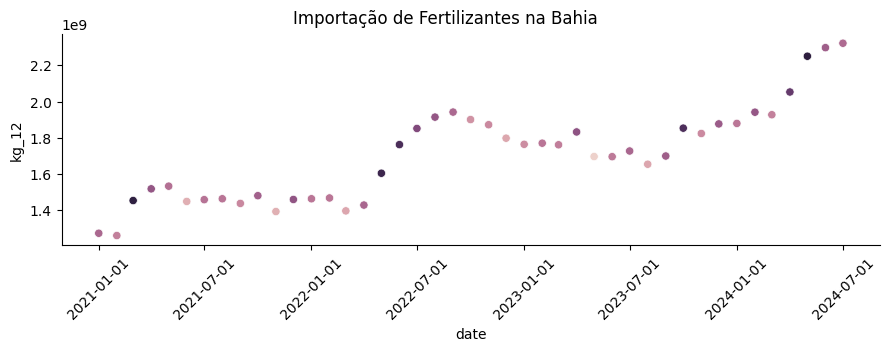

In [4]:
sns.relplot(data=i_ba,x='date',y='kg_12',hue='dif_kg',legend=False,height=3,aspect=3).set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia')
plt.show()

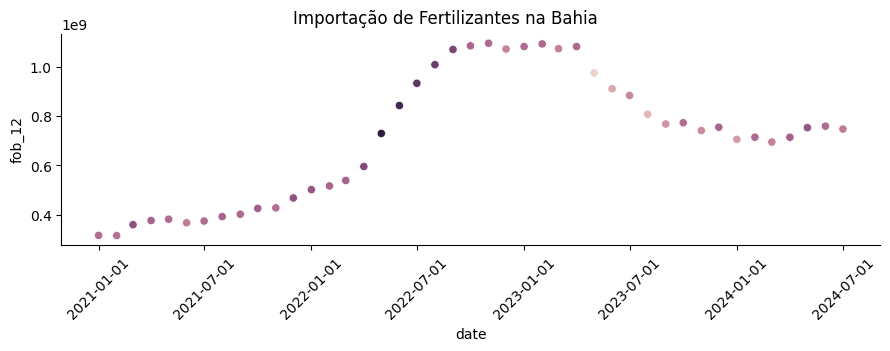

In [5]:
sns.relplot(data=i_ba,x='date',y='fob_12',hue='dif_fob',height=3,aspect=3,legend=False).set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia')
plt.show()

In [6]:
i_ba=i_1.groupby(by=['date','NO_SH4_POR'])[['VL_FOB','KG_LIQUIDO']].sum().reset_index()

In [7]:
i_ba['CO_MES']=i_ba.date.astype('datetime64[ns]').dt.month
i_ba['CO_ANO']=i_ba.date.astype('datetime64[ns]').dt.year

In [8]:
i_ba=i_ba[~i_ba.NO_SH4_POR.str.contains('vegetal')]

# MUNICÍPIO IMPORTADOR

In [9]:
i_mes_mun=i_1.groupby(by=['date','NO_MUN'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
top_mun=i_mes_mun[i_mes_mun.date.dt.year>2020].groupby('NO_MUN').KG_LIQUIDO.sum().reset_index().sort_values(by=['KG_LIQUIDO']).NO_MUN.tail(3).tolist()
top_mun

['CONCEICAO DO JACUIPE', 'LUIS EDUARDO MAGALHAES', 'CANDEIAS']

In [10]:
i_mes_mun['Município']='Outros'
i_mes_mun.loc[i_mes_mun.NO_MUN.isin(top_mun),'Município']=i_mes_mun[i_mes_mun.isin(top_mun)].NO_MUN
i_mes_mun=i_mes_mun.groupby(by=['date','Município'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
q=pd.DataFrame()
for mun in i_mes_mun.Município.unique():
    it=i_mes_mun[i_mes_mun.Município==mun].sort_values('date')
    it['kg_12']=it.rolling(12).KG_LIQUIDO.sum()
    it['fob_12']=it.rolling(12).VL_FOB.sum()
    it['dif_kg']=it.kg_12-it.shift(1).kg_12
    it['dif_fob']=it.fob_12-it.shift(1).fob_12
    q=pd.concat([q,it]).dropna()

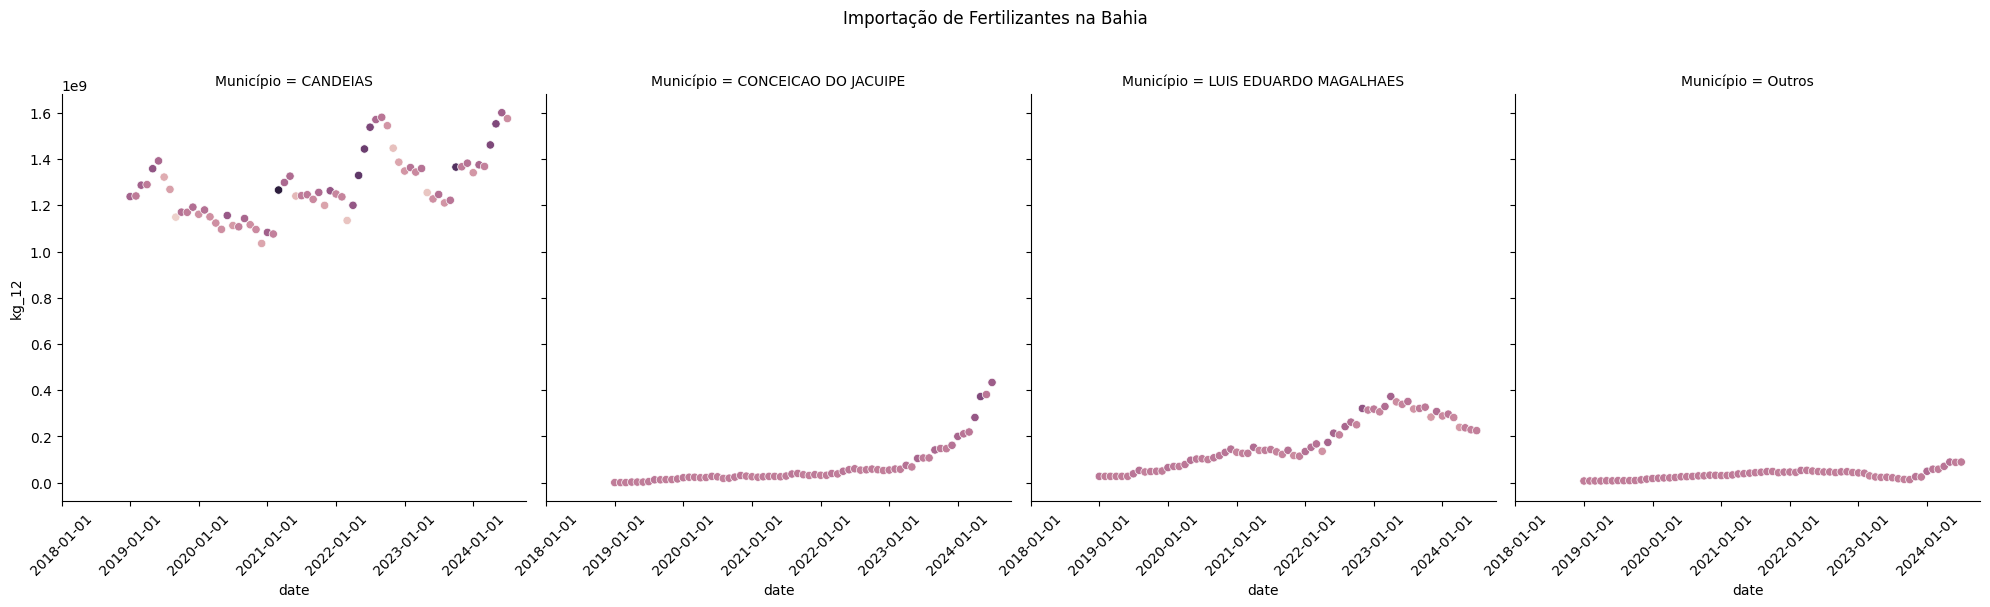

In [11]:
sns.relplot(data=q,x='date',y='kg_12',hue='dif_kg',legend=False,  col='Município').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

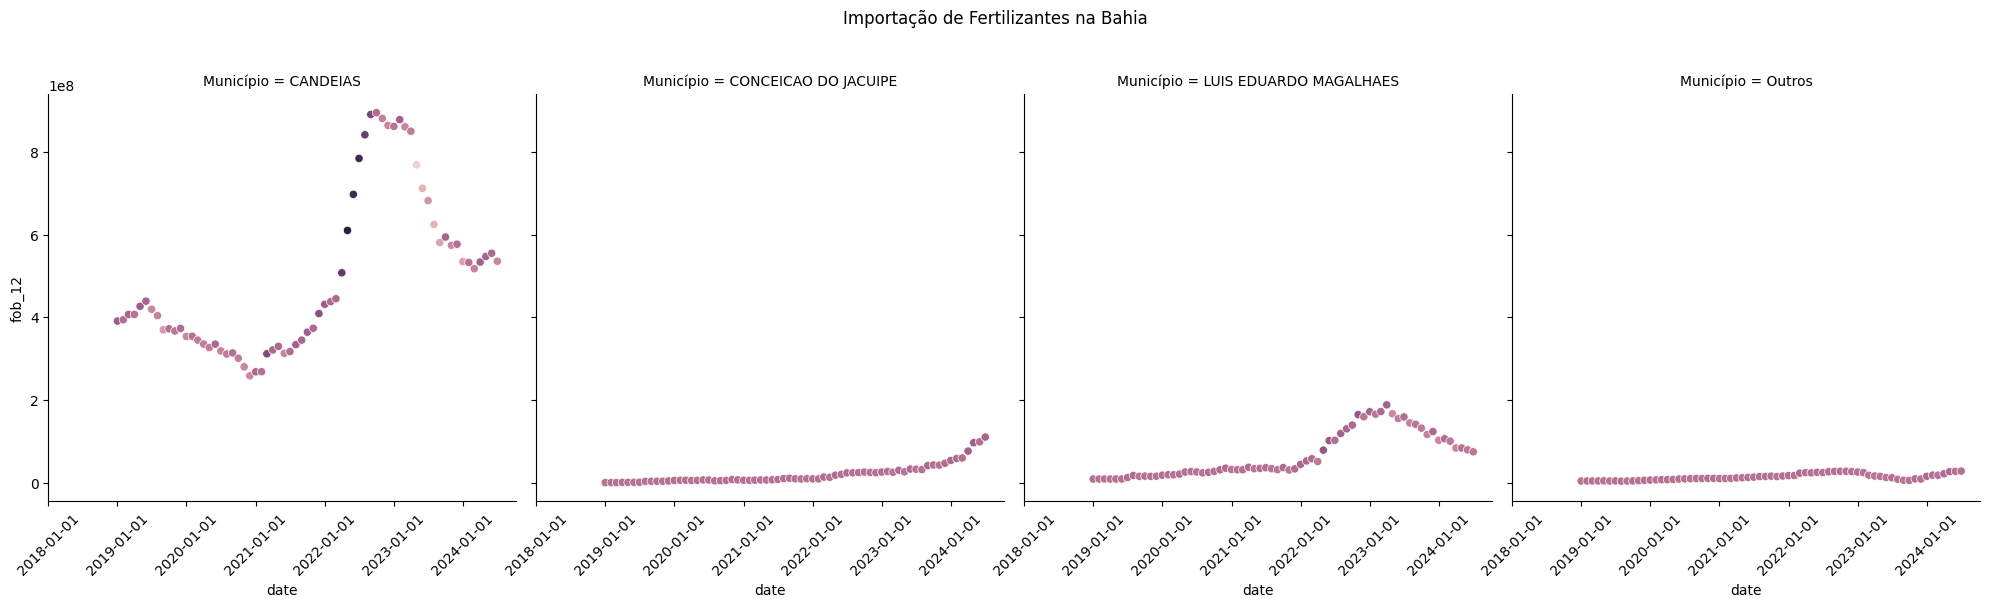

In [12]:
sns.relplot(data=q,x='date',y='fob_12',hue='dif_fob',legend=False,  col='Município').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

# SH4

In [13]:
i_mes_sh4=i_1.groupby(by=['date','NO_SH4_POR'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()

top_sh4=i_mes_sh4[i_mes_sh4.date.dt.year>2020].groupby('NO_SH4_POR').KG_LIQUIDO.sum().reset_index().sort_values(by=['KG_LIQUIDO']).NO_SH4_POR.tail(3).tolist()

i_mes_sh4['sh4_top']='outros'
i_mes_sh4.loc[i_mes_sh4.NO_SH4_POR.isin(top_sh4),'sh4_top']=i_mes_sh4[i_mes_sh4.isin(top_sh4)].NO_SH4_POR
i_mes_sh4=i_mes_sh4.groupby(by=['date','sh4_top'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
q=pd.DataFrame()
for sh4 in i_mes_sh4.sh4_top.unique():
    it=i_mes_sh4[i_mes_sh4.sh4_top==sh4].sort_values('date')
    it['kg_12']=it.rolling(12).KG_LIQUIDO.sum()
    it['fob_12']=it.rolling(12).VL_FOB.sum()
    it['dif_kg']=it.kg_12-it.shift(1).kg_12
    it['dif_fob']=it.fob_12-it.shift(1).fob_12
    q=pd.concat([q,it]).dropna()

q.sh4_top=q.sh4_top.str.replace('Adubos (fertilizantes) minerais ou químicos, ', '')

q.sh4_top=q.sh4_top.str.replace('azotados', 'nitrogenados')

q.sh4_top=q.sh4_top.str.replace('contendo dois ou três dos seguintes elementos fertilizantes: azoto (nitrogénio), fósforo e potássio; outros adubos (fertilizantes); produtos do presente capítulo apresentados em tabletes ou formas semelhantes, ', 'NP_NK_PK_NPK')

In [14]:
q.sh4_top.unique()

array(['nitrogenados', 'NP_NK_PK_NPK', 'potássicos', 'outros'],
      dtype=object)

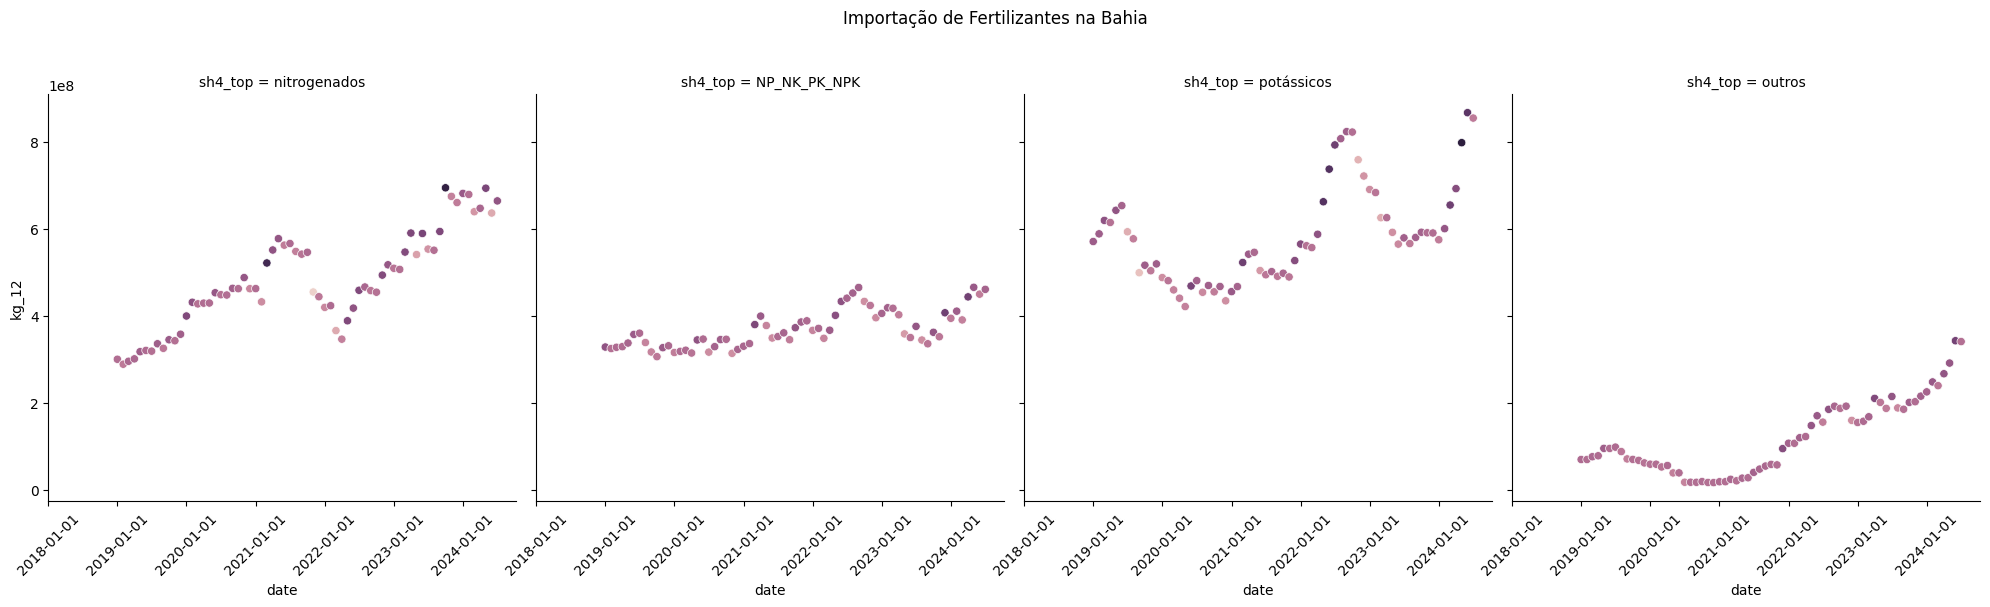

In [15]:
sns.relplot(data=q,x='date',y='kg_12',hue='dif_kg',legend=False,  col='sh4_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

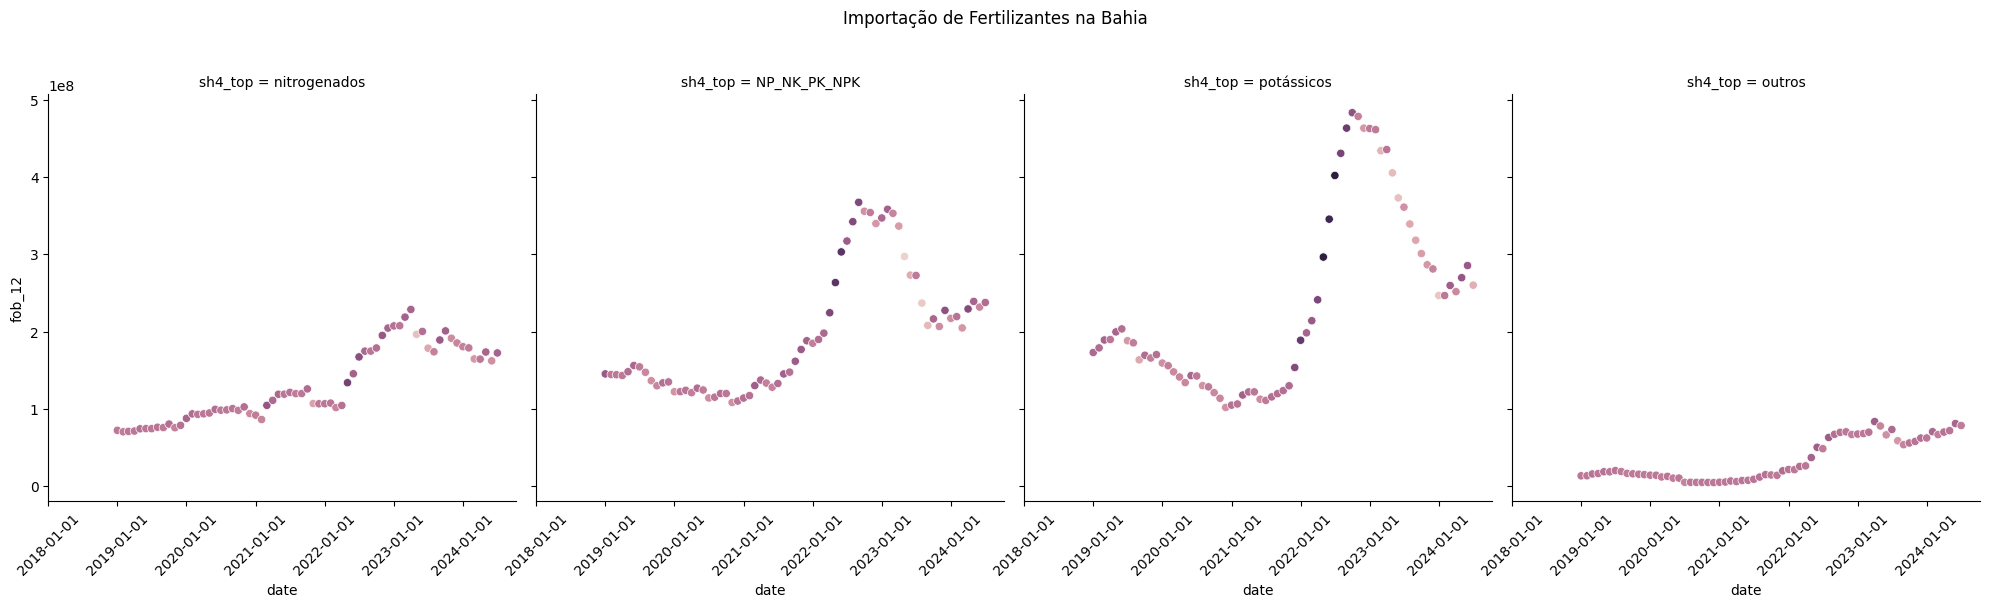

In [16]:
sns.relplot(data=q,x='date',y='fob_12',hue='dif_fob',legend=False,  col='sh4_top').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

# Município e SH4

In [17]:
i_mes_mun_sh4=i_1.groupby(by=['date','NO_MUN','NO_SH4_POR'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()

In [18]:
i_mes_mun_sh4['sh4_top']='Outros'
i_mes_mun_sh4.loc[i_mes_mun_sh4.NO_SH4_POR.isin(top_sh4),'sh4_top']=i_mes_mun_sh4[i_mes_mun_sh4.isin(top_sh4)].NO_SH4_POR

i_mes_mun_sh4['Município']='Outros'
i_mes_mun_sh4.loc[i_mes_mun_sh4.NO_MUN.isin(top_mun),'Município']=i_mes_mun_sh4[i_mes_mun_sh4.isin(top_mun)].NO_MUN

i_mes_mun_sh4=i_mes_mun_sh4.groupby(by=['date','Município','sh4_top'],observed=False)[['KG_LIQUIDO','VL_FOB']].sum().reset_index()

q=pd.DataFrame()
for sh4 in i_mes_mun_sh4.sh4_top.unique():
    for mun in i_mes_mun_sh4.Município.unique():
        
        it=i_mes_mun_sh4[(i_mes_mun_sh4.sh4_top==sh4)&(i_mes_mun_sh4.Município==mun)].sort_values('date')
        
        it['kg_12']=it.rolling(12).KG_LIQUIDO.sum()
        it['fob_12']=it.rolling(12).VL_FOB.sum()
        it['dif_kg']=it.kg_12-it.shift(1).kg_12
        it['dif_fob']=it.fob_12-it.shift(1).fob_12
        q=pd.concat([q,it]).dropna()

In [19]:
q.sh4_top=q.sh4_top.str.replace('Adubos (fertilizantes) minerais ou químicos, ', '')

q.sh4_top=q.sh4_top.str.replace('azotados', 'nitrogenados')

q.sh4_top=q.sh4_top.str.replace('contendo dois ou três dos seguintes elementos fertilizantes: azoto (nitrogénio), fósforo e potássio; outros adubos (fertilizantes); produtos do presente capítulo apresentados em tabletes ou formas semelhantes, ', 'NP_NK_PK_NPK')

In [20]:
q=q[q.Município.isin(['CONCEICAO DO JACUIPE','CANDEIAS','LUIS EDUARDO MAGALHAES'])]

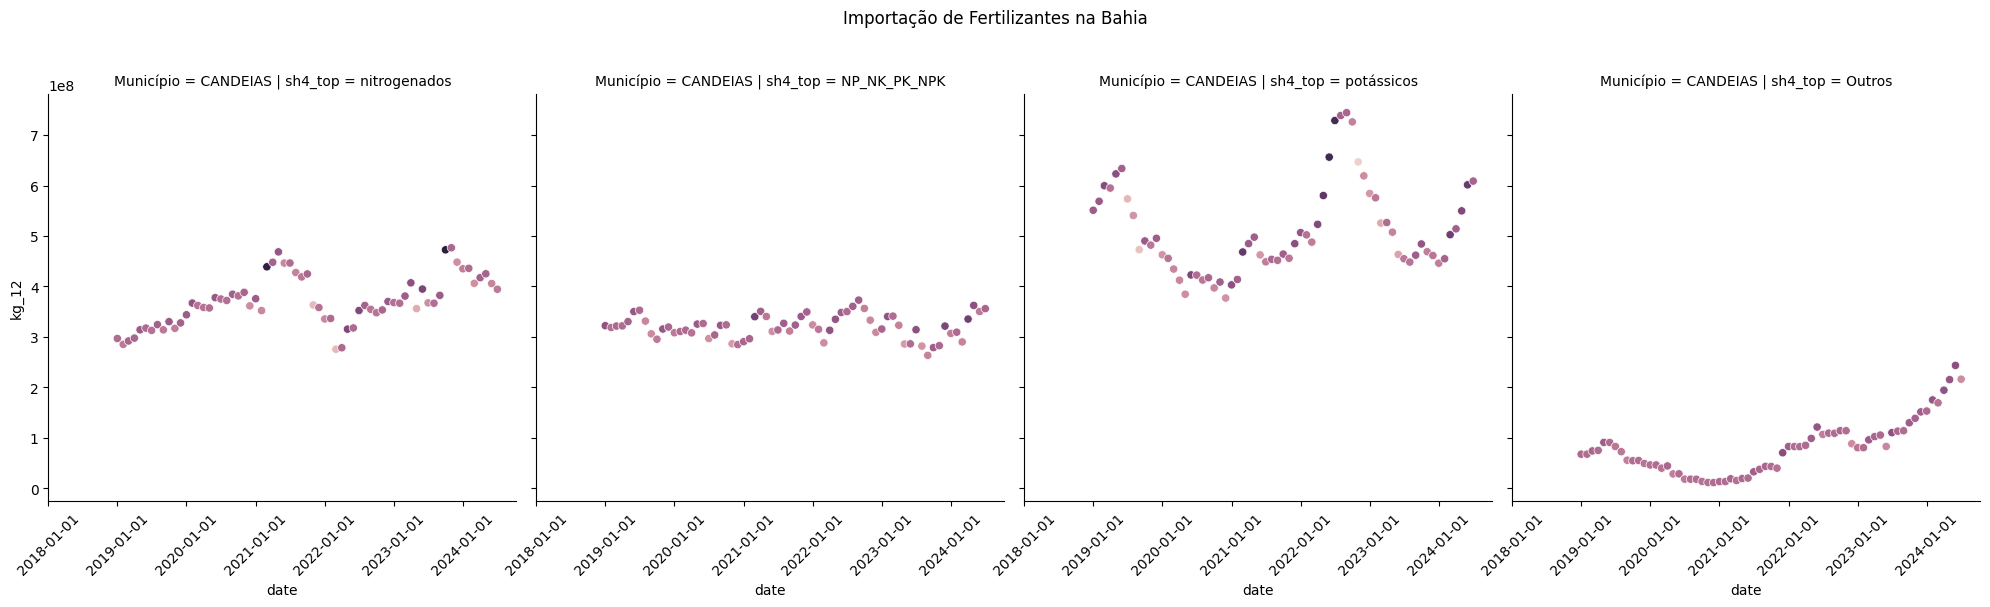

In [21]:
sns.relplot(data=q[q.Município=='CANDEIAS'],x='date',y='kg_12',hue='dif_kg',legend=False,  col='sh4_top',row='Município').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

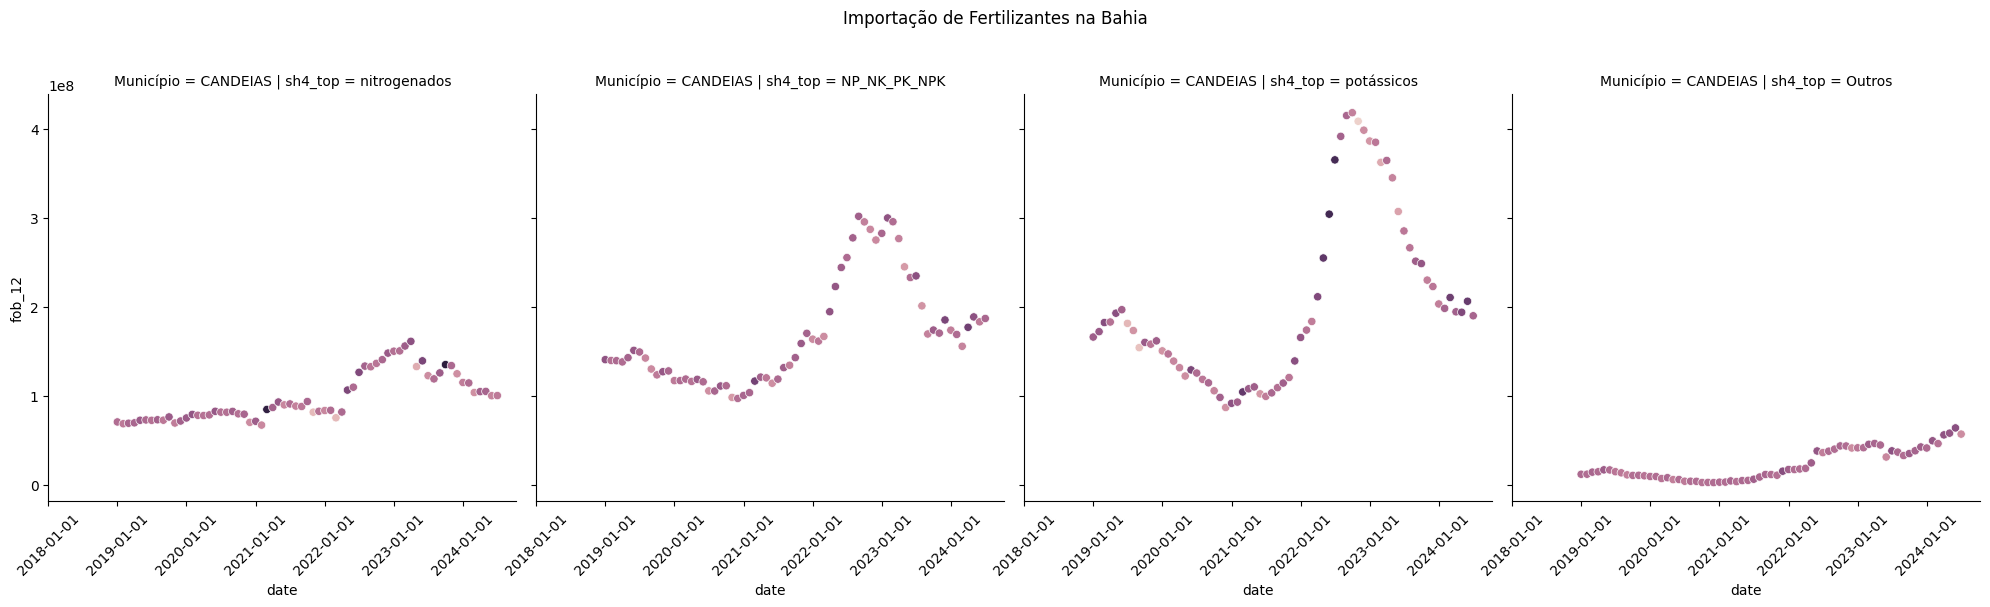

In [22]:
sns.relplot(data=q[q.Município=='CANDEIAS'],x='date',y='fob_12',hue='dif_kg',legend=False,  col='sh4_top',row='Município').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

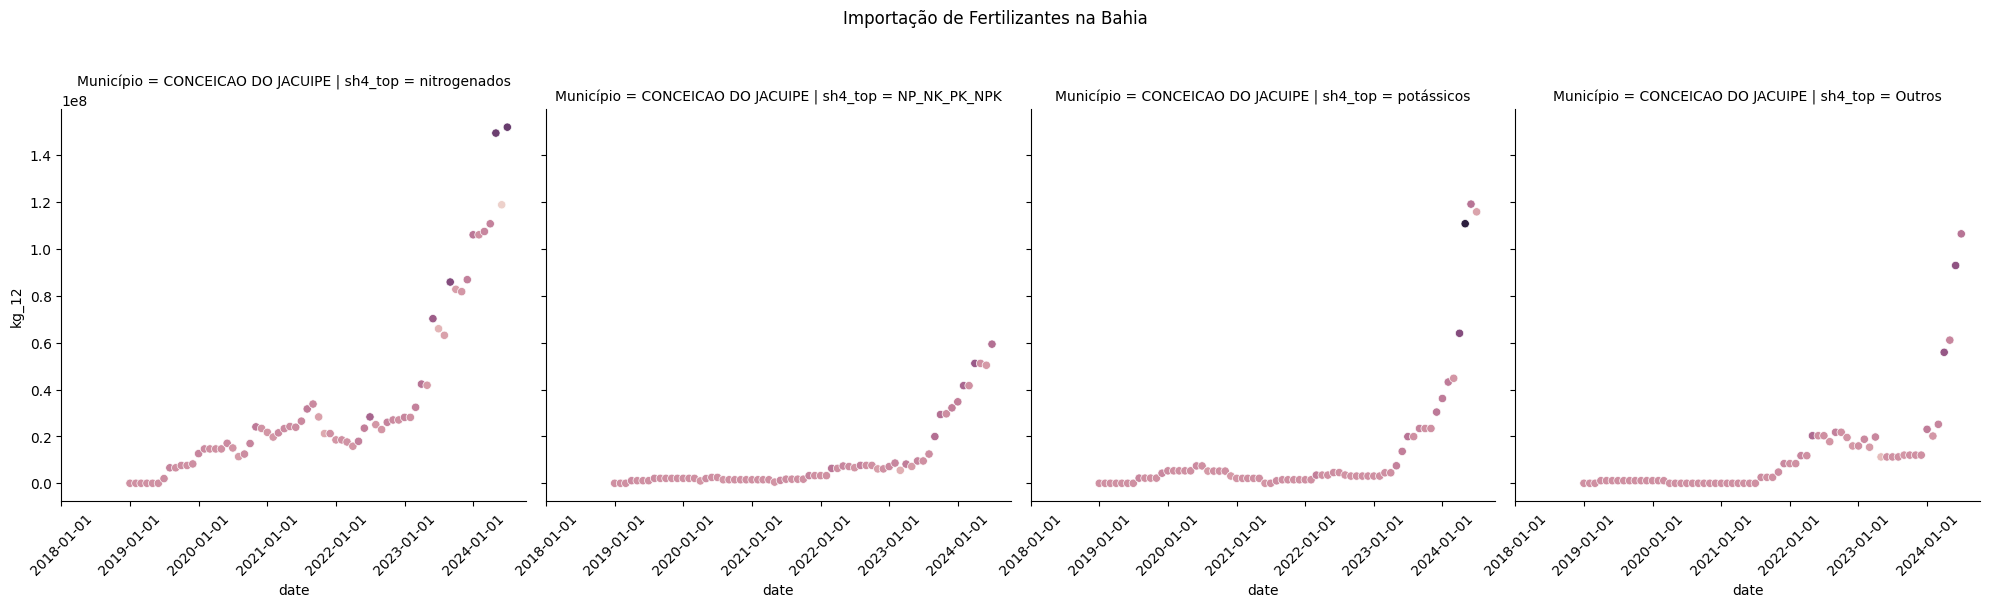

In [23]:
sns.relplot(data=q[q.Município=='CONCEICAO DO JACUIPE'],x='date',y='kg_12',hue='dif_fob',legend=False,  col='sh4_top',row='Município').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

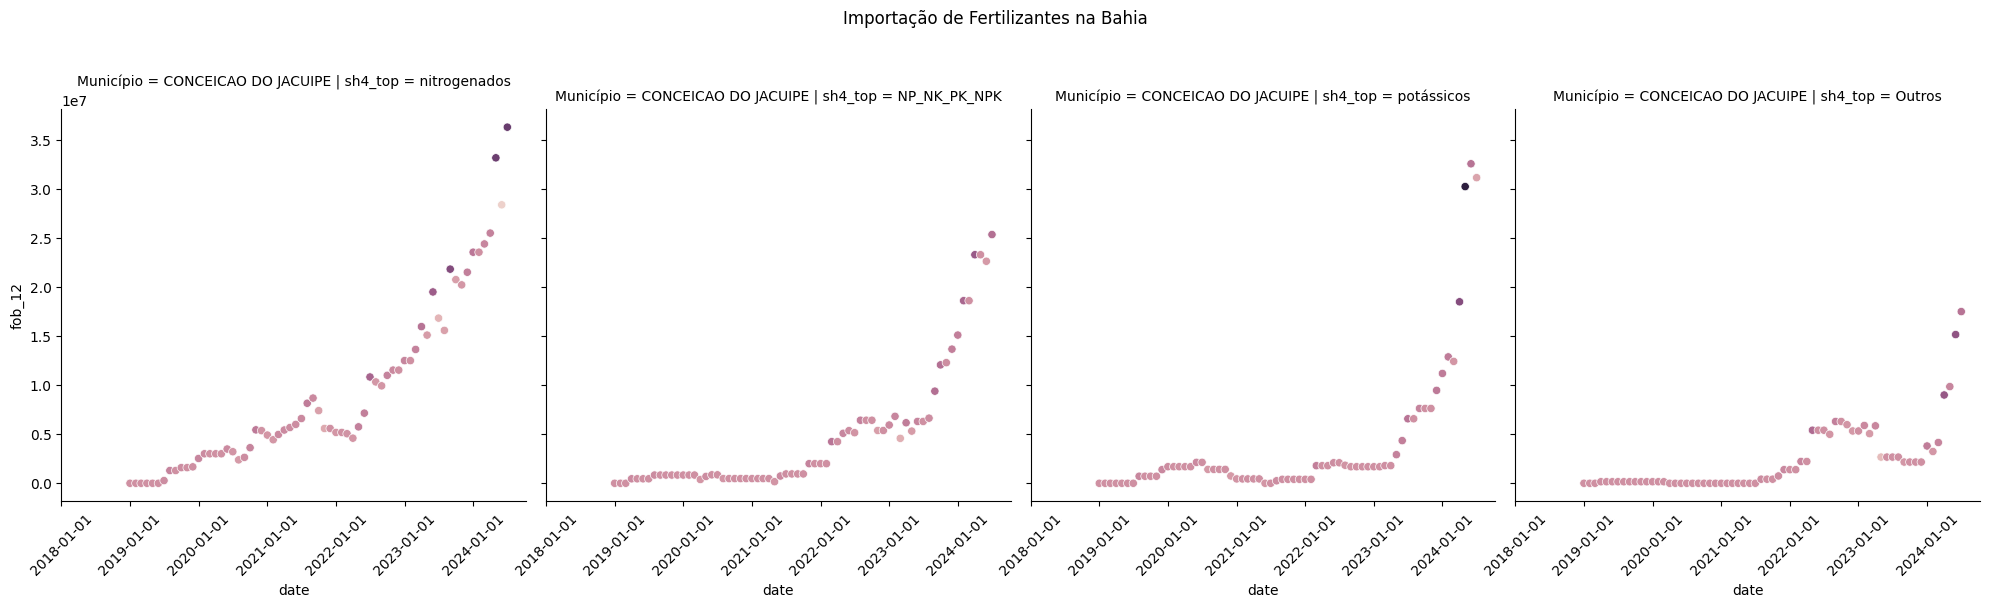

In [24]:
sns.relplot(data=q[q.Município=='CONCEICAO DO JACUIPE'],x='date',y='fob_12',hue='dif_fob',legend=False,  col='sh4_top',row='Município').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

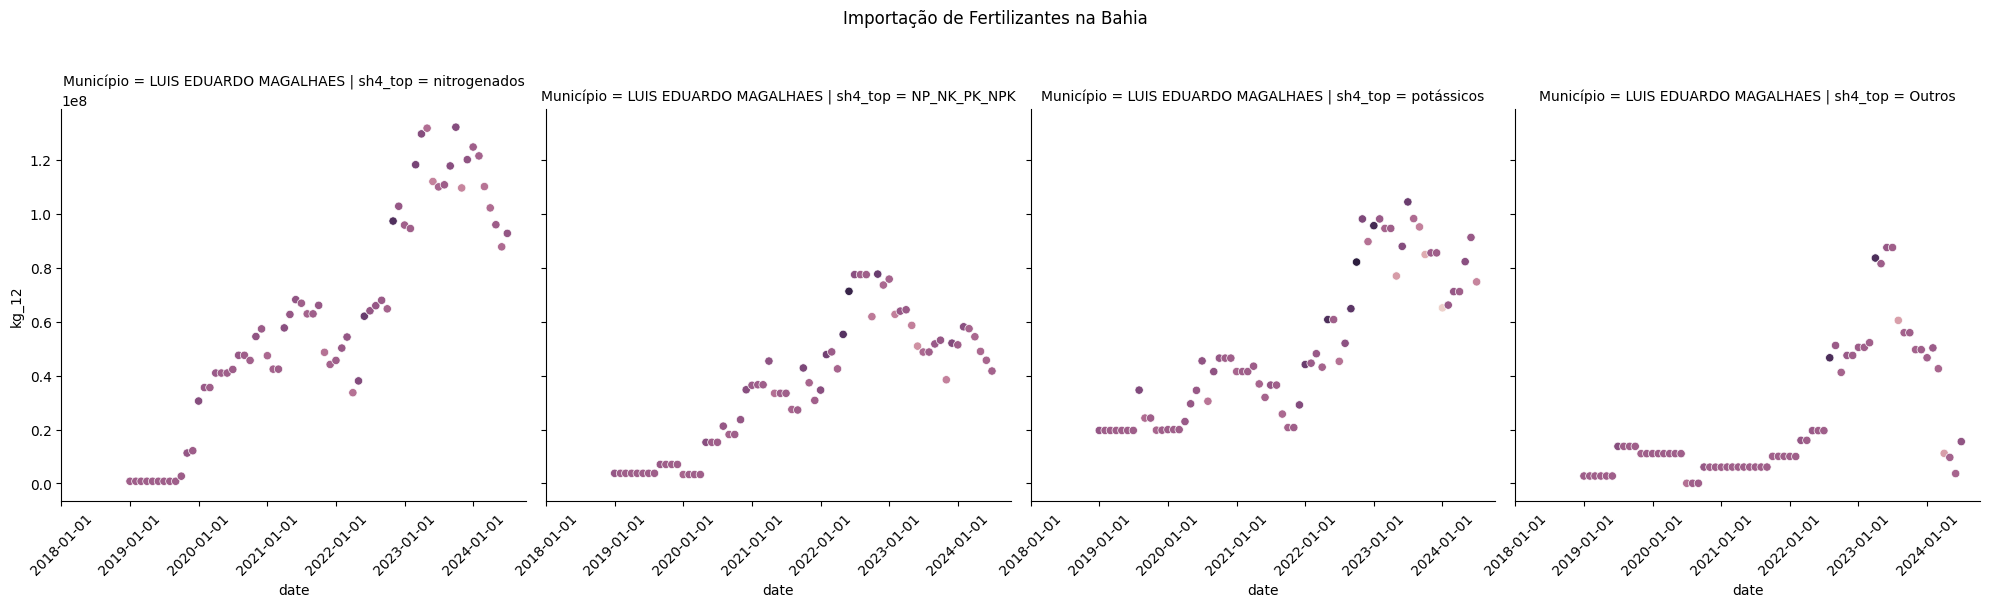

In [25]:
sns.relplot(data=q[q.Município=='LUIS EDUARDO MAGALHAES'],x='date',y='kg_12',hue='dif_fob',legend=False,  col='sh4_top',row='Município').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

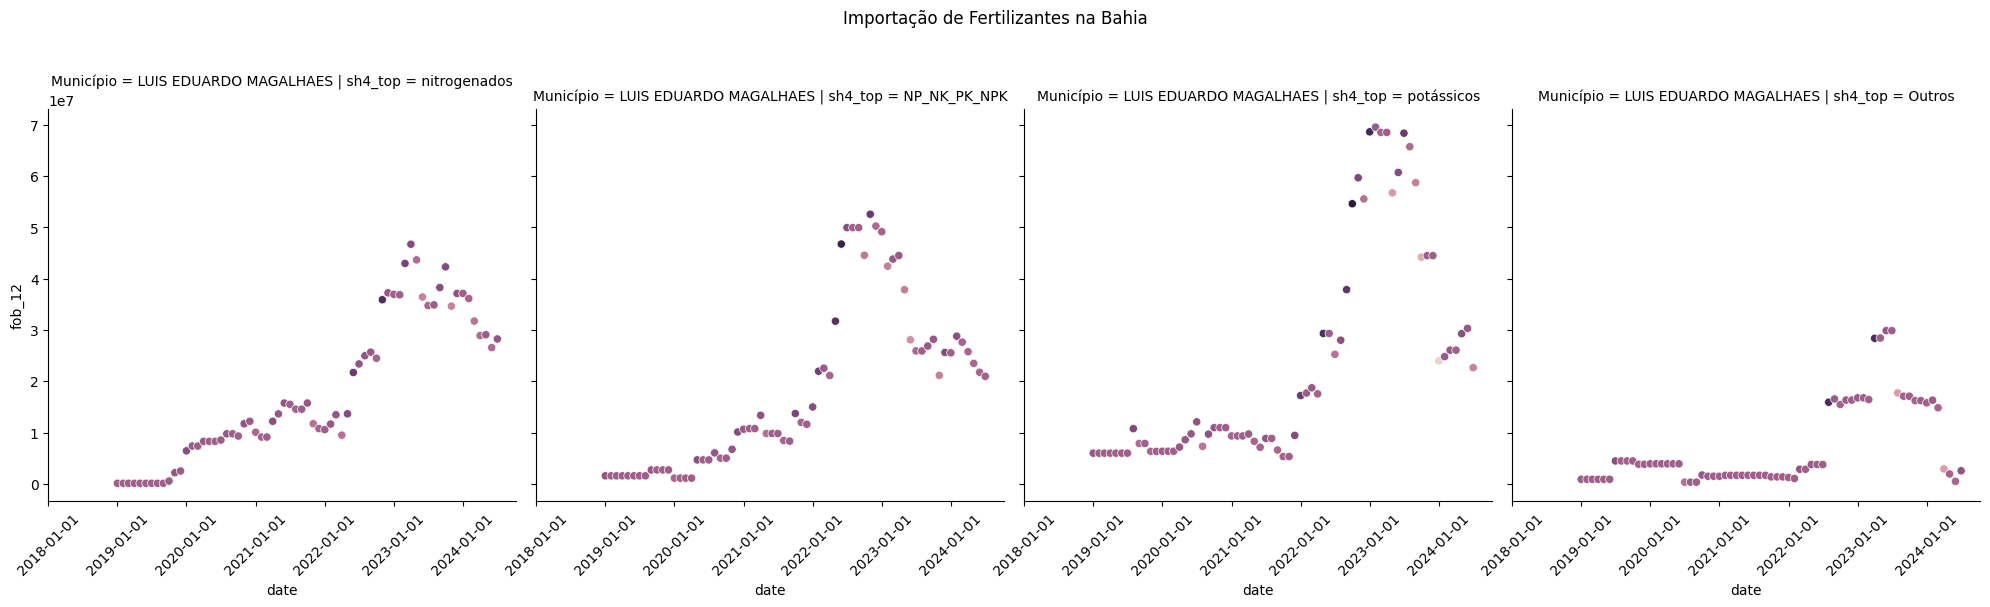

In [26]:
sns.relplot(data=q[q.Município=='LUIS EDUARDO MAGALHAES'],x='date',y='fob_12',hue='dif_fob',legend=False,  col='sh4_top',row='Município').set_xticklabels(rotation=45).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

# Município e País

In [27]:
i_mun_pais=i_1.groupby(by=['date','NO_MUN','NO_PAIS'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()
i_mun_pais

,date,NO_MUN,NO_PAIS,KG_LIQUIDO,VL_FOB
0,2018-01-01,CAMACARI,Alemanha,0,0
1,2018-01-01,CAMACARI,Argentina,0,0
2,2018-01-01,CAMACARI,Argélia,0,0
3,2018-01-01,CAMACARI,Arábia Saudita,0,0
4,2018-01-01,CAMACARI,Austrália,0,0
...,...,...,...,...,...
54189,2024-07-01,VITORIA DA CONQUISTA,Turquia,0,0
54190,2024-07-01,VITORIA DA CONQUISTA,Ucrânia,0,0
54191,2024-07-01,VITORIA DA CONQUISTA,Uzbequistão,0,0
54192,2024-07-01,VITORIA DA CONQUISTA,Venezuela,0,0


In [28]:
top_pais=i_mun_pais[i_mun_pais.date.dt.year>2020].groupby('NO_PAIS').KG_LIQUIDO.sum()\
.reset_index().sort_values(by=['KG_LIQUIDO']).NO_PAIS.tail(10).tolist()

In [29]:
top_mun=['CANDEIAS','CONCEICAO DO JACUIPE']

In [30]:
i_mun_pais['pais_top']='Outros'

In [31]:
i_mun_pais.head(1)

,date,NO_MUN,NO_PAIS,KG_LIQUIDO,VL_FOB,pais_top
0,2018-01-01,CAMACARI,Alemanha,0,0,Outros


In [32]:
i_mun_pais.loc[i_mun_pais.NO_PAIS.isin(top_pais),'pais_top']=i_mun_pais[i_mun_pais.isin(top_pais)].NO_PAIS

In [33]:
i_mun_pais['Município']='Outros'
i_mun_pais.loc[i_mun_pais.NO_MUN.isin(top_mun),'Município']=i_mun_pais[i_mun_pais.isin(top_mun)].NO_MUN

i_mun_pais=i_mun_pais.groupby(by=['date','Município','pais_top'],observed=False)[['KG_LIQUIDO','VL_FOB']].sum().reset_index()

q=pd.DataFrame()
for pais in i_mun_pais.pais_top.unique():
    for mun in i_mun_pais.Município.unique():
        
        it=i_mun_pais[(i_mun_pais.pais_top==pais)&(i_mun_pais.Município==mun)].sort_values('date')
        
        it['kg_12']=it.rolling(12).KG_LIQUIDO.sum()
        it['fob_12']=it.rolling(12).VL_FOB.sum()
        it['dif_kg']=it.kg_12-it.shift(1).kg_12
        it['dif_fob']=it.fob_12-it.shift(1).fob_12
        q=pd.concat([q,it]).dropna()

In [34]:
q

,date,Município,pais_top,KG_LIQUIDO,VL_FOB,kg_12,fob_12,dif_kg,dif_fob
396,2019-01-01,CANDEIAS,Alemanha,8000000,2743613,8000000.0,2743613.0,8000000.0,2743613.0
429,2019-02-01,CANDEIAS,Alemanha,0,0,8000000.0,2743613.0,0.0,0.0
462,2019-03-01,CANDEIAS,Alemanha,0,0,8000000.0,2743613.0,0.0,0.0
495,2019-04-01,CANDEIAS,Alemanha,0,0,8000000.0,2743613.0,0.0,0.0
528,2019-05-01,CANDEIAS,Alemanha,0,0,8000000.0,2743613.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2474,2024-03-01,Outros,Rússia,0,0,80501727.0,36205501.0,-15800000.0,-6639920.0
2507,2024-04-01,Outros,Rússia,1605243,784852,79106269.0,35125393.0,-1395458.0,-1080108.0
2540,2024-05-01,Outros,Rússia,6406641,3812385,78507187.0,35013522.0,-599082.0,-111871.0
2573,2024-06-01,Outros,Rússia,359000,157820,70869624.0,30203072.0,-7637563.0,-4810450.0


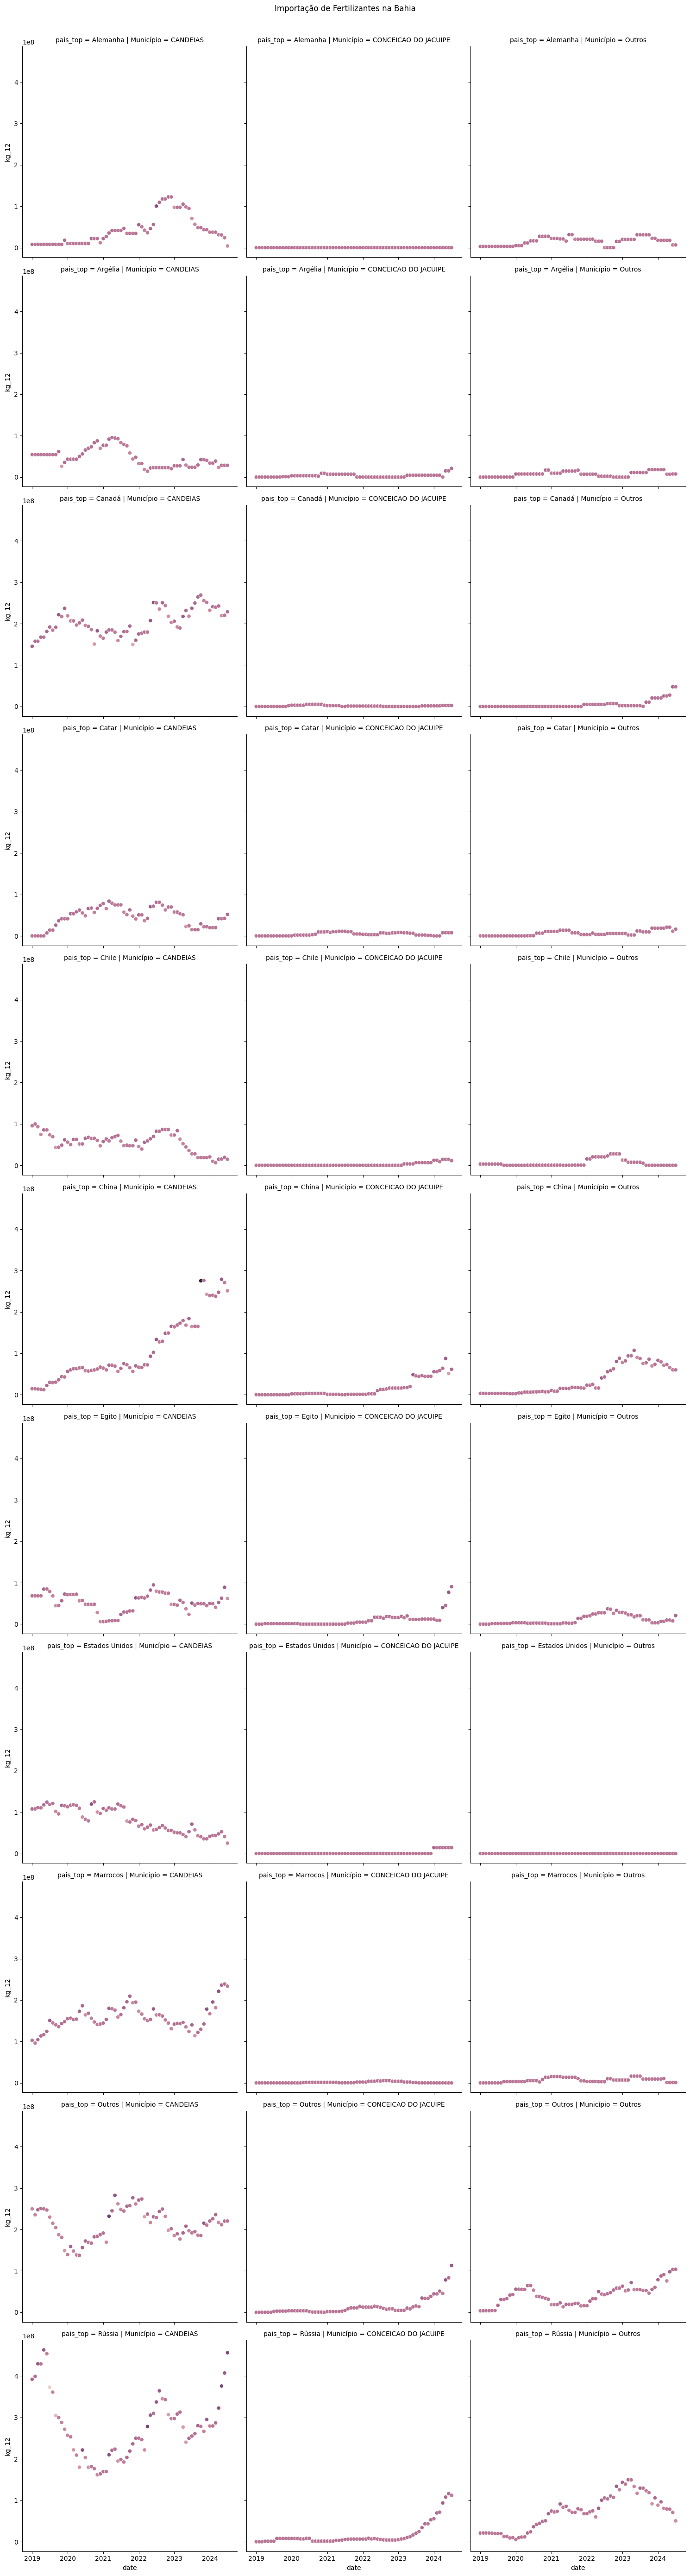

In [35]:
sns.relplot(data=q,x='date',y='kg_12',hue='dif_kg',legend=False,  row='pais_top', col='Município').fig.suptitle('Importação de Fertilizantes na Bahia',y=1.01)
plt.show()

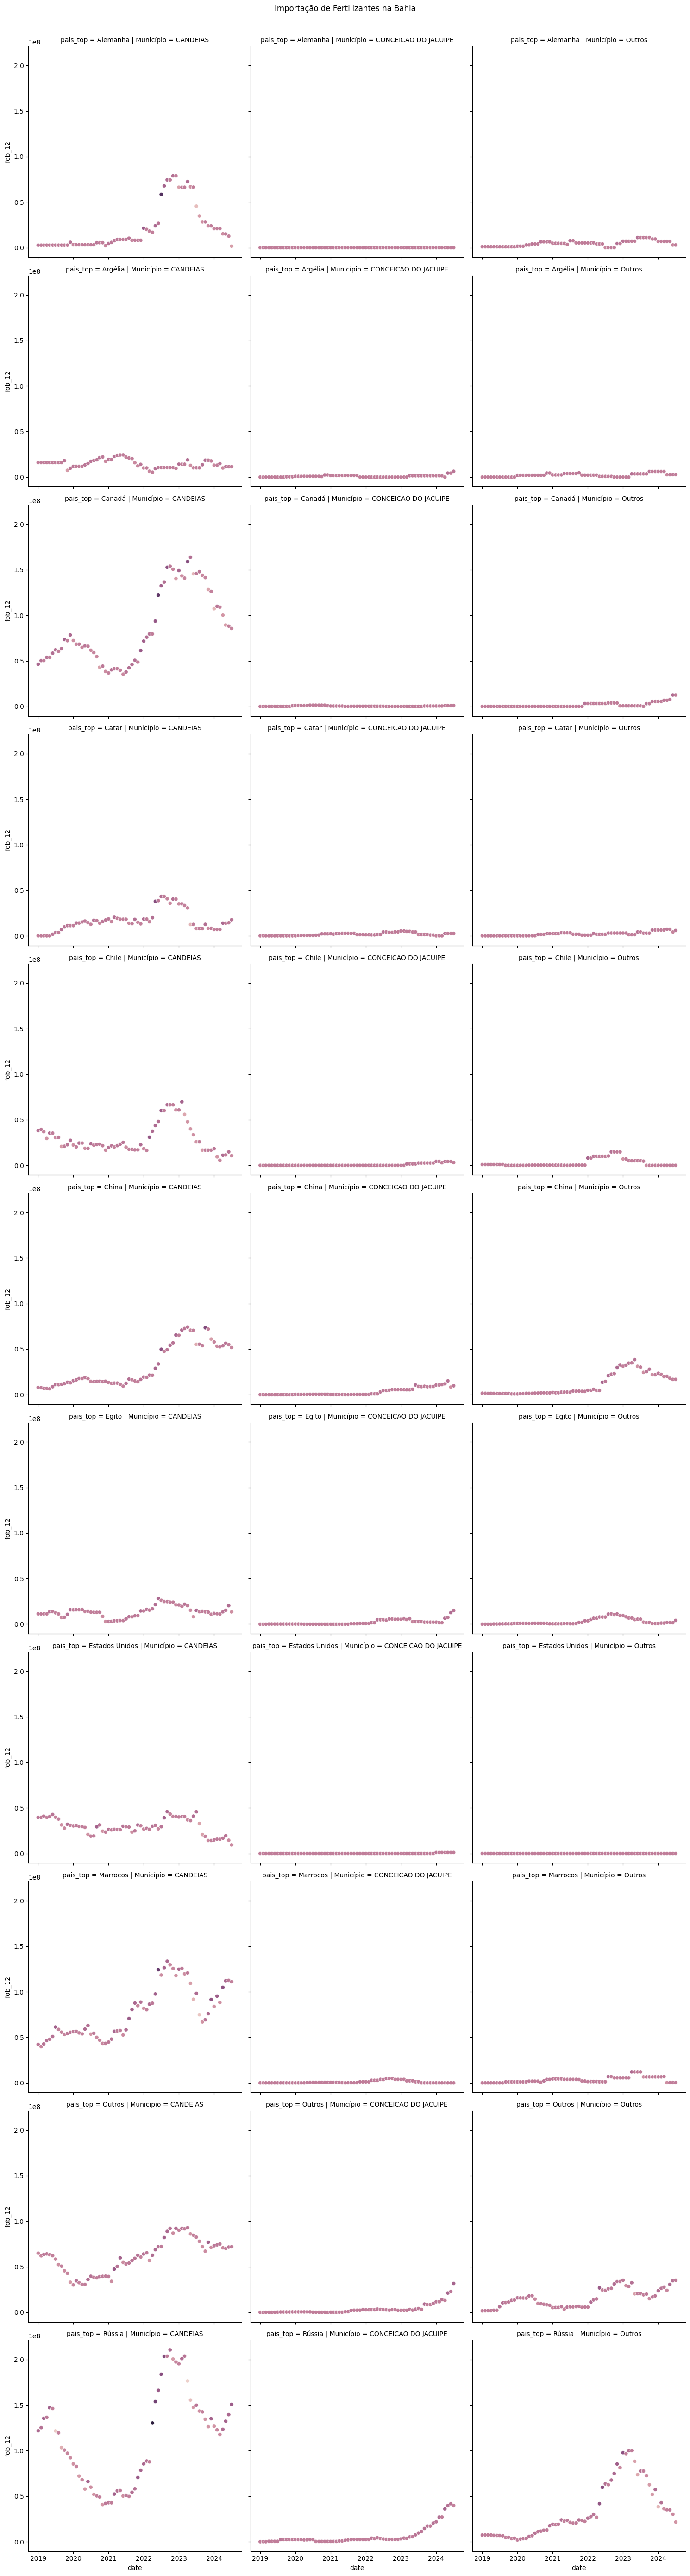

In [36]:
sns.relplot(data=q,x='date',y='fob_12',hue='dif_fob',legend=False,  row='pais_top', col='Município').fig.suptitle('Importação de Fertilizantes na Bahia',y=1.01)
plt.show()